# Model Elastic Moduli

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from scipy.interpolate import interp1d

data_dir='/fd1/QibinShi_data/England_farm/'

## 1. Load physical data

In [3]:
phy_paras = pd.read_csv(data_dir + 'Soil_phy.csv')

phy_1 = phy_paras.loc[phy_paras['Plot'].between(1,9)]
phy_2 = phy_paras.loc[phy_paras['Plot'].between(10,18)]
phy_3 = phy_paras.loc[phy_paras['Plot'].between(19,27)]

phy_1['ind'] = 36 - phy_1['Plot'] 
phy_2['ind'] = 33 - phy_2['Plot']
phy_3['ind'] = 30 - phy_3['Plot']

phy_all = pd.concat([phy_1, phy_2, phy_3])
phy_10cm = phy_all.loc[phy_all['Depth (cm)'] == 10]
phy_20cm = phy_all.loc[phy_all['Depth (cm)'] == 20]
phy_30cm = phy_all.loc[phy_all['Depth (cm)'] == 30]

<ipython-input-3-dd0ca59cd14b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_1['ind'] = 36 - phy_1['Plot']
<ipython-input-3-dd0ca59cd14b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phy_2['ind'] = 33 - phy_2['Plot']
<ipython-input-3-dd0ca59cd14b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

#### The distance of the physical data has been roughly calibrated. We can plot them with distance

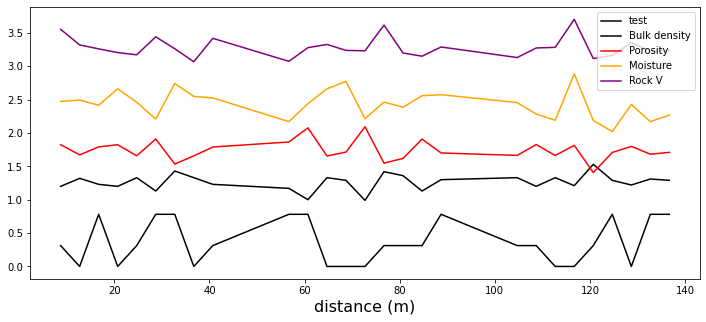

In [7]:
plt.figure(figsize=(12, 5))
# plt.plot(np.arange(len(v))*dchan, v, label='dvv(max-min)', lw=6)
# plt.plot(np.arange(len(b))*dchan, b/80, label='intb(max-min)', color='g', lw=6)

plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['tillage'])/32, label='test', color='k')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Dry Bulk density (g/cm3)']), label='Bulk density', color='k')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)'])/30, label='Porosity', color='r')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Moisture content (%)'])/6, label='Moisture', color='orange')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Rock volume (%)'])/10+3, label='Rock V', color='purple')

plt.xlabel("distance (m)", fontsize = 16)
# plt.ylabel("dv / v", fontsize = 16)
plt.legend()
# plt.ylim(-0.8, 0.8)

### Bulk density at different depths

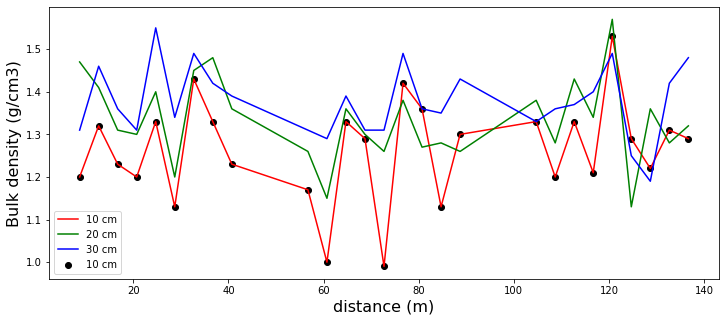

In [17]:
plt.figure(figsize=(12, 5))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Dry Bulk density (g/cm3)']), label='10 cm', color='k')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Dry Bulk density (g/cm3)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Dry Bulk density (g/cm3)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Dry Bulk density (g/cm3)']), label='30 cm', color='b')

plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Bulk density (g/cm3)", fontsize = 16)
plt.legend()

### Porosity at different depths (inversely proportional to bulk density)

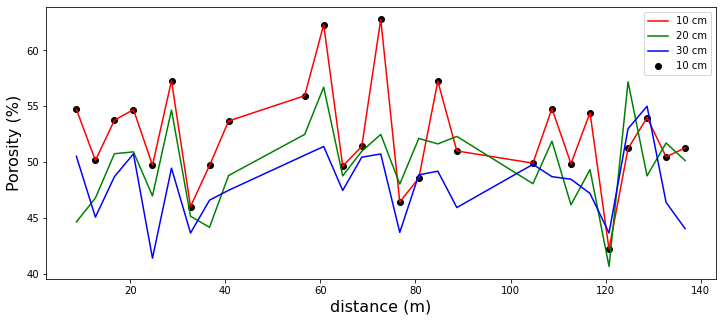

In [19]:
plt.figure(figsize=(12, 5))
plt.scatter(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='k')
plt.plot(np.array(phy_10cm['ind'])*4-3.3, np.array(phy_10cm['Porosity (%)']), label='10 cm', color='r')
plt.plot(np.array(phy_20cm['ind'])*4-3.3, np.array(phy_20cm['Porosity (%)']), label='20 cm', color='g')
plt.plot(np.array(phy_30cm['ind'])*4-3.3, np.array(phy_30cm['Porosity (%)']), label='30 cm', color='b')

plt.xlabel("distance (m)", fontsize = 16)
plt.ylabel("Porosity (%)", fontsize = 16)
plt.legend()

## 2. Formula from Solazzi et al. (2021)

In [124]:
class litho:
    def __init__(self, bulk_density, porosity, N, f, s):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from K_d, actually
        self.N = N
        self.f = f
        self.s = s  ## Saturation

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Poisson's ratio 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))

        ## Partially saturated soil (Biot-Gassmann)
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Moduli of drained soil (Hertz-Mindlin)
        P_e = (self.rho - self.rho_a) * 9.8 * 0.1
        self.K_d = (N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*f-(1+3*f)*nu) / (2 - nu) / 5
        print(nu, self.G_d)

    
    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d

        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)

        return self.vp, self.vs, self.K, self.G, self.rho
    


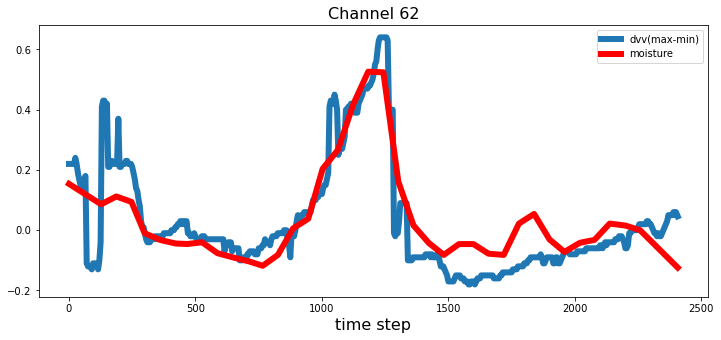

In [121]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv(max-min)', lw=6)
plt.plot(np.arange(len(moisture)), (90-moisture)/50, label='moisture', color='r', lw=6)

plt.xlabel("time step", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

In [122]:
phy_10cm_ch62 = phy_10cm.loc[phy_10cm['ind'] == int((3.19 * 12 + 3.3) / 4 )]
phy_10cm_ch62

,Plot,Treatments,tillage,Depth (cm),Dry Bulk density (g/cm3),Porosity (%),Moisture content (%),Rock volume (%),ind
57,20,STP Zero,0,10,1.33,49.7,15.28,0.67,10


In [152]:
bulk_density = phy_10cm_ch62['Dry Bulk density (g/cm3)'].values[0] * 1000
porosity = phy_10cm_ch62['Porosity (%)'].values[0] / 100

soil_ch62_sand = litho(bulk_density, porosity, 6, 0.1, moisture/100)
soil_ch62_clay = litho(bulk_density, porosity, 8, 0.3, moisture/100)

0.07419354838709677 [39986121.42483769 39987134.85468084 39988148.23315808 ...
 40504284.39216317 40505827.60138238 40507370.69302279]
0.07419354838709677 [60650719.63403942 60652256.79861293 60653793.8852749  ...
 61436666.25091933 61439006.98181184 61441347.5343615 ]


In [153]:
_, vs_sand, K_sand, G_sand, rho_sand = soil_ch62_sand.get_vp_vs()
_, vs_clay, K_clay, G_clay, rho_clay = soil_ch62_clay.get_vp_vs()


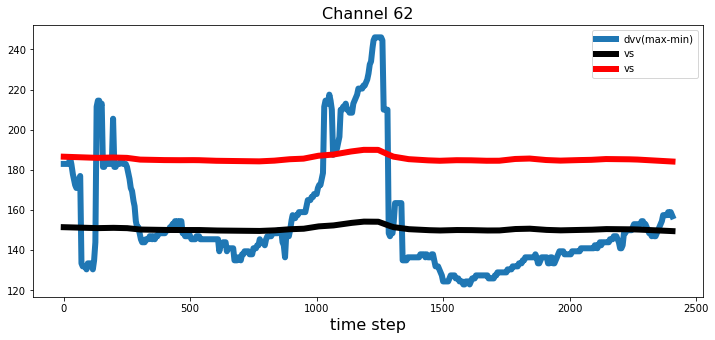

In [154]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(dvv)), dvv*150, label='dvv(max-min)', lw=6)
# plt.plot(np.arange(len(moisture)), moisture/100, label='s', color='r', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand, label='vs', color='k', lw=6)
plt.plot(np.arange(len(moisture)), vs_clay, label='vs', color='r', lw=6)


plt.xlabel("time step", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()